In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, Input
from keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [2]:
(X_train,y_train), (X_test,y_test) = mnist.load_data()
X_train = X_train.reshape((X_train.shape[0], 28, 28, 1))
X_test = X_test.reshape((X_test.shape[0], 28, 28, 1))
# one hot encode target values
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

11501568/11490434 [==============================] - 0s 0us/step


In [3]:
def model():
    inputs = Input(shape=(28,28,1))
    x = Conv2D(24,kernel_size=(3,3),padding='same',activation="relu")(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(48, (3, 3), padding='same',activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(64, (3, 3), padding='same',activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.25)(x)
    output = Dense(10,activation="softmax")(x)
    
    model = Model(inputs,output)
    
    model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
    
    return model

In [4]:
cnn = model()
cnn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 24)        240       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 24)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 48)        10416     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 48)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)          27712 

In [5]:
history = cnn.fit(X_train,y_train,
         epochs=2,
         batch_size=32,
         validation_data=(X_test,y_test))

Epoch 1/2
1875/1875 [==============================] - 73s 39ms/step - loss: 0.3453 - accuracy: 0.9197 - val_loss: 0.0587 - val_accuracy: 0.9824
Epoch 2/2
1875/1875 [==============================] - 72s 38ms/step - loss: 0.0889 - accuracy: 0.9745 - val_loss: 0.0468 - val_accuracy: 0.9859


In [6]:
layer_outputs = [layer.output for layer in cnn.layers[1:7]]
activation_model = Model(inputs=cnn.input,outputs=layer_outputs)

(-0.5, 27.5, 27.5, -0.5)

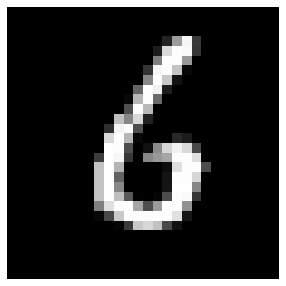

In [8]:
img = X_test[50].reshape(1,28,28,1)
fig = plt.figure(figsize=(5,5))
plt.imshow(img[0,:,:,0],cmap="gray")
plt.axis('off')

In [9]:
activations = activation_model.predict(img)

In [11]:
for layer in cnn.layers:
  print(layer.name)

input_1
conv2d
max_pooling2d
conv2d_1
max_pooling2d_1
conv2d_2
max_pooling2d_2
flatten
dense
dropout
dense_1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


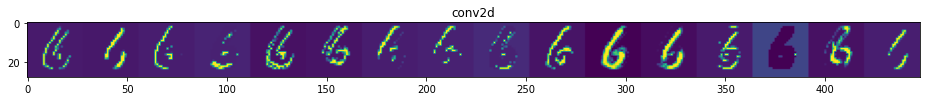

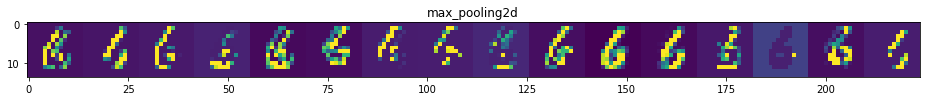

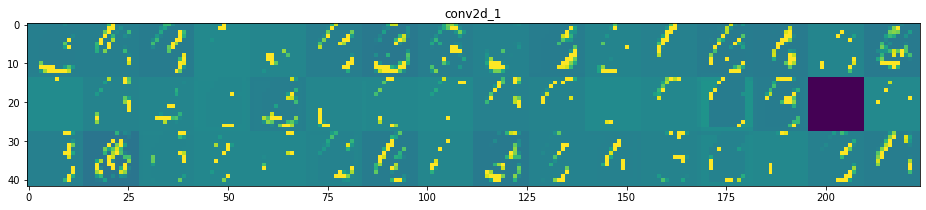

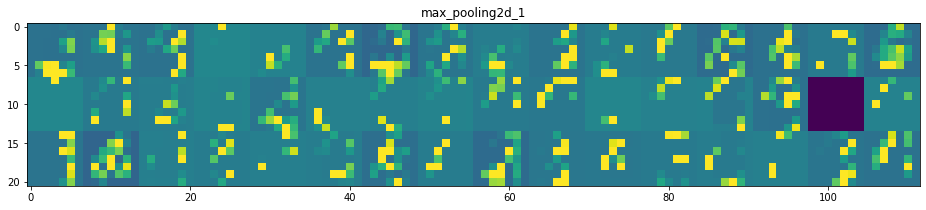

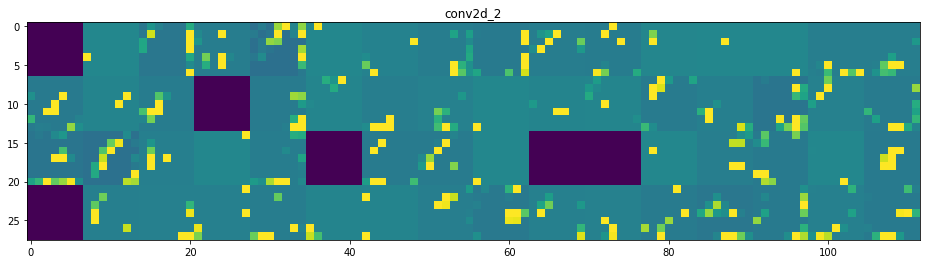

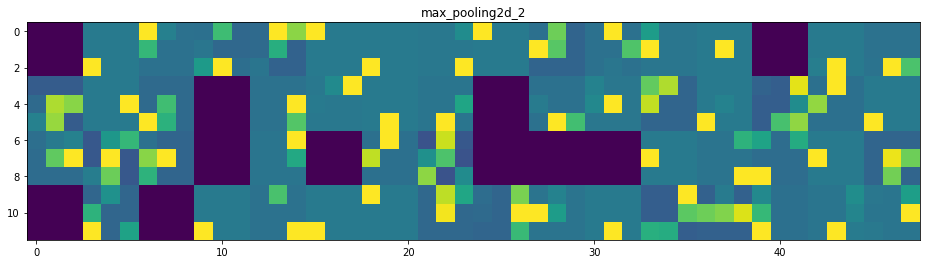

In [10]:
layer_names = []
for layer in cnn.layers[1:7]:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
    
images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')